In [1]:
from IPython.core.display import display, HTML
import GPy, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
display(HTML("<style>.container { width:100% !important;align=center; }</style>"))
np.set_printoptions(precision=4, linewidth=200)

import seaborn as snb
snb.set(font_scale = 2.)

from scipy.stats import norm

In [163]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [62]:
def plot_with_uncertainty(x, y, ystd=None, color='r', linestyle='-', fill=True, label='', ax=None):
    
    if ax is None:
        ax = plt
  
    ax.plot(x, y, color=color, linestyle=linestyle, label=label)

    if not ystd is None:
        lower, upper = y - ystd, y + ystd

    ax.plot(x, lower, color=color, alpha=0.5, linestyle=linestyle)
    ax.plot(x, upper, color=color, alpha=0.5, linestyle=linestyle)

    if fill:
        ax.fill_between(x.ravel(), lower.ravel(), upper.ravel(), color=color, alpha=0.25, linestyle=linestyle)


### Code

In [130]:

def sample(xp, xd, z, num_samples, scale, variance):
    se = GPy.kern.RBF(input_dim = 1, lengthscale=scale, variance=variance)
    se_der = GPy.kern.DiffKern(se, 0)

    gauss = GPy.likelihoods.Gaussian(variance=sigma2)
    probit = GPy.likelihoods.Binomial(gp_link = GPy.likelihoods.link_functions.Probit(nu=20, fixed=False))
    
    x = y = np.zeros((0, 1))

    # Then create the model, we give everything in lists
    m = GPy.core.MultioutputGP(X_list=[x, xd], Y_list=[y, z], kernel_list=[se, se_der], likelihood_list = [gauss, probit], inference_method=GPy.inference.latent_function_inference.EP(ep_mode="nested"))
    
    X = np.zeros((len(xp), 2))
    X[:, 0] = xp.ravel()
        
    mu, Sigma = m.predict(X, include_likelihood=False, full_cov=True)

    L = np.linalg.cholesky(Sigma + 1e-9*np.identity(Sigma.shape[0]))


    return mu + np.dot(L, np.random.normal(0, 1, size = (len(mu), num_samples)))

def run_regular_gp(x, y, xp, xtest, sigma2, scale, variance):
    
    rbf = GPy.kern.RBF(input_dim=1, lengthscale=scale, variance=variance)
    model = GPy.models.GPRegression(x, y, kernel=rbf, noise_var=sigma2)
    
    mu, var = model.predict(xp, include_likelihood=True)
    mu_test, var_test = model.predict(xtest, include_likelihood=True)
    return mu, var, mu_test, var_test

def run_regular_mono(x, y, xd, z, xp, xtest, sigma2, scale, variance):
    
    se = GPy.kern.RBF(input_dim = 1, lengthscale=scale, variance=variance)
    se_der = GPy.kern.DiffKern(se, 0)

    gauss = GPy.likelihoods.Gaussian(variance=sigma2)
    probit = GPy.likelihoods.Binomial(gp_link = GPy.likelihoods.link_functions.Probit(nu=20, fixed=False))

    m = GPy.core.MultioutputGP(X_list=[x, xd], Y_list=[y, z], kernel_list=[se, se_der], likelihood_list = [gauss, probit], inference_method=GPy.inference.latent_function_inference.EP(ep_mode="nested"))

    X = np.zeros((len(xp), 2))
    X[:, 0] = xp.ravel()
    Xtest = np.zeros((len(xtest), 2))
    Xtest[:, 0] = xtest.ravel()
    
    mu, var = m.predict(X, include_likelihood=False)
    mu_test, var_test = m.predict(Xtest, include_likelihood=False)
    var = var + sigma2
    var_test = var_test + sigma2
    return mu, var, mu_test, var_test

log_npdf = lambda x, m, v: -(x-m)**2/(2*v) -0.5*np.log(2*np.pi*v)

def compute_mlppd(ytest, m, v):
    return np.sum(log_npdf(ytest, m, v))


def compute_mse(ytest, m, v):
    return np.mean((ytest-m)**2)



### Params

In [179]:
xp = np.linspace(-5, 5, 301)[:, None]


sigma2 = 1e-1
scale = 3.5
variance = 2


# observations of f'
M = 31
xd = np.linspace(-5, 5, M)[:, None]
m = np.ones((M, 1))

np.random.seed(0)
p = 0.5
Nfull = int(p*len(xp))
Ntest = len(xp) - Nfull

num_samples = 100


In [180]:
# sample
idx_full = np.random.choice(range(Nfull), size=Nfull, replace=False)
Ntrains = np.arange(10, 100+1, 10)

results_mu = np.zeros((num_samples, len(Ntrains), len(xp)))
results_var =  np.zeros((num_samples, len(Ntrains), len(xp)))
results_mlppd = np.zeros((num_samples, len(Ntrains)))
results_mse = np.zeros((num_samples, len(Ntrains)))

results_mu_mono = np.zeros((num_samples, len(Ntrains), len(xp)))
results_var_mono =  np.zeros((num_samples, len(Ntrains), len(xp)))
results_mlppd_mono = np.zeros((num_samples, len(Ntrains)))
results_mse_mono = np.zeros((num_samples, len(Ntrains)))
                         
# sample true functions
fs = sample(xp, xd, m, num_samples, scale, variance)

plot = False

for idx_sample in range(num_samples):

    f = fs[:, idx_sample][:, None]
    ftest = f[Nfull:]
    ytest = ftest + np.random.normal(0, np.sqrt(sigma2), size=(Ntest, 1))
    xtest = xp[Nfull:, :]

    print('%d,' % idx_sample, end='')
    
    if plot:
        plt.figure(figsize=(30, 40))
    
    for idx_train, Ntrain in enumerate(Ntrains):

        idx = idx_full[:Ntrain]        
        x = xp[idx]
        y = f[idx] + np.random.normal(0, np.sqrt(sigma2), size=(Ntrain, 1))

        # regular gp
        mu, var, mu_test, var_test = run_regular_gp(x, y, xp, xtest, sigma2, scale, variance)                     
        results_mlppd[idx_sample, idx_train] = compute_mlppd(ytest, mu_test, var_test)
        results_mse[idx_sample, idx_train] = compute_mse(ytest, mu_test, var_test)
        results_mu[idx_sample, idx_train, :] = mu.ravel()
        results_var[idx_sample, idx_train, :] = var.ravel()
        
        # mono gp
        mu_mono, var_mono, mu_test_mono, var_test_mono = run_regular_mono(x, y, xd, m, xp, xtest, sigma2, scale, variance)                     
        results_mlppd_mono[idx_sample, idx_train] = compute_mlppd(ytest, mu_test_mono, var_test_mono)
        results_mse_mono[idx_sample, idx_train] = compute_mse(ytest, mu_test_mono, var_test_mono)
        results_mu_mono[idx_sample, idx_train, :] = mu_mono.ravel()
        results_var_mono[idx_sample, idx_train, :] = var_mono.ravel()

        if plot:
            plt.subplot(7, 3, 1 + idx_train)

            #plt.plot(xtest, ftest, 'b-', linewidth=3,linestyle='--')
            plt.plot(xtest, ytest, 'b.')
            plt.plot(x, y, 'b.', markersize=10)
            plt.axvline(xtest[0], linestyle='--', color='k', alpha=0.5)

            plot_with_uncertainty(xp, mu, var, color='r')
            plot_with_uncertainty(xp, mu_mono, var_mono, color='g')
            plt.plot(xp, f, 'k--')
            plt.title('Run %d, N = %d' % (idx_sample, Ntrain))


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

Text(0.5,0,'Number of training samples')

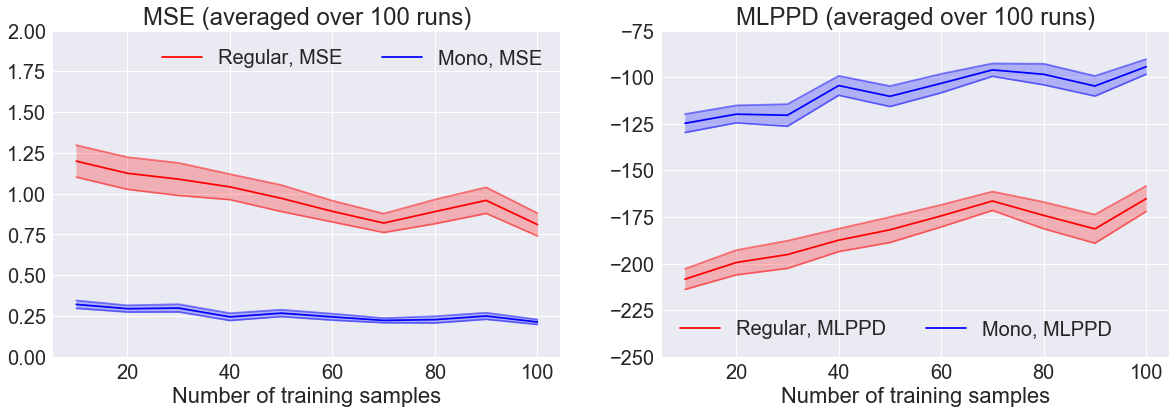

In [183]:
def plot_results(x, data, color, label):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)/np.sqrt(len(data))
    plot_with_uncertainty(Ntrains, mean, std, color=color, label=label)

max_mse = np.max((np.max(results_mse), np.max(results_mse_mono)))
min_lppd = np.max((np.min(results_mlppd), np.min(results_mlppd_mono)))
max_lppd = np.max((np.max(results_mlppd), np.max(results_mlppd_mono)))

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plot_results(Ntrain, results_mse, 'r', 'Regular, MSE')
plot_results(Ntrain, results_mse_mono, 'b', 'Mono, MSE')
plt.title('MSE (averaged over %d runs)' % num_samples)
plt.legend(ncol=2)
plt.ylim((0, 2))
plt.xlabel('Number of training samples')

plt.subplot(1, 2, 2)
plot_results(Ntrain, results_mlppd, 'r', 'Regular, MLPPD')
plot_results(Ntrain, results_mlppd_mono, 'b', 'Mono, MLPPD')
plt.title('MLPPD (averaged over %d runs)' % num_samples)
plt.legend(ncol=2)
plt.ylim((-250, -75))
plt.xlabel('Number of training samples')